# INET 4710 Midterm Project
## Group 4

Jacob Isler (isle0011@umn.edu), Mehul Thakkar (thakk020@umn.edu), Trevor Moos (moosx035@umn.edu), and Jacob Sampson (samps294@umn.edu)

## **Overview**

### Business Problem

Understand the underlying causes for food inspection failures in Chicago using data collected from inspections around the city of Chicago.

### Objective Goals

Address the following:

1. Why restaurants and other food establishments in the city of Chicago fail food inspections.

2. How food inspectors can proactively help restaurants and other food establishments avoid failing inspections.

3. If food inspection failures may be biased against certain types of facilities or neighborhoods, and how the food inspection process could be improved.

4. If food inspection failures can be accurately predicted.

5. How many distinct groups of restaurant and food establishment do we have? What are risks and opportunities associated with each group?

6. Any other relevant details or findings related to the core problem she is facing. 


## **Data/Data Cleanup**

The data we are using comes from HealthData.gov (https://healthdata.gov/dataset/food-inspections).  The site describes the dataset in the following way:

*This information is derived from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. Inspections are performed by staff from the Chicago Department of Public Health’s Food Protection Program using a standardized procedure.*

The fields in the dataset include the name of the business being inspected, its location, its business category, when the inspection was carried out, the type of inspection, and the results of the inspection (with notes).

In [ ]:
#import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load file from URL
FILE_LOCATION = 'https://data.cityofchicago.org/api/views/4ijn-s7e5/rows.csv'
df = pd.read_csv(FILE_LOCATION)

Let's take an initial look at the data, and see what needs to be cleaned up

In [ ]:
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2484995,ASIAN MIX,ASIAN MIX,1798497.0,Restaurant,Risk 1 (High),3945 N BROADWAY,CHICAGO,IL,60613.0,02/22/2021,Canvass,Pass,NaN,41.954096,-87.650072,"(-87.65007225130127, 41.954095576616304)"
1,2453550,BIAN,BIAN,2744751.0,Restaurant,Risk 1 (High),600 W CHICAGO AVE,CHICAGO,IL,60654.0,10/20/2020,License,Pass,NaN,41.896585,-87.642996,"(-87.64299618172501, 41.896585191199556)"
2,2453473,GREEN DRAGON,GREEN DRAGON,2677175.0,Restaurant,Risk 2 (Medium),4650 S INDIANA,CHICAGO,IL,60653.0,10/16/2020,License,Not Ready,NaN,41.809625,-87.621369,"(-87.62136886092523, 41.809624617912505)"
3,2402000,TORTAZO WILLIS,TORTAZO WILLIS,2689749.0,Restaurant,Risk 1 (High),233 S WACKER DR,CHICAGO,IL,60606.0,10/05/2020,Canvass,Pass,NaN,41.878560,-87.636524,"(-87.63652387205532, 41.87856015362371)"
4,2401782,NIPSEY'S,NIPSEY'S,2637334.0,Restaurant,Risk 1 (High),9156 S STONY ISLAND AVE,CHICAGO,IL,60617.0,09/29/2020,License Re-Inspection,Pass,NaN,41.727952,-87.585580,"(-87.58558036137349, 41.72795237840198)"


In [ ]:
df.shape

(216750, 17)

In [ ]:
df.Results.unique()

array(['Pass', 'Not Ready', 'No Entry', 'Out of Business', 'Fail',
       'Pass w/ Conditions', 'Business Not Located'], dtype=object)

We see 216,458 rows of uncleaned data with 17 factors. The target variable is the result of the inspections, stored in `Results`.

In [ ]:
Pass = sum(df['Results'] == 'Pass')
Fail = sum(df['Results'] == 'Fail')
Other = sum((df['Results'] != 'Pass') & (df['Results'] != 'Fail'))
print('Pass: ', Pass)
print('Fail: ', Fail)
print('Other: ', Other)

Pass:  113345
Fail:  41791
Other:  61614


We remove results without clear passing indications (`No Entry`, `Not Ready`, `Out of Business`, `Pass w/ Conditions`, `Business Not Located`), keeping the rows with `Pass` and `Fail` as the results.

In [ ]:
df = df.loc[(df['Results'] == 'Pass') | (df['Results'] == 'Fail')]

In [ ]:
df.shape

(155136, 17)

After filtering the records with unclear outputs, we have 154,997 rows of data.

Let's breakdown the fields to see where data cleaning is needed.  Currently the fields in the dataset are:

In [ ]:
list(df.columns) 

['Inspection ID',
 'DBA Name',
 'AKA Name',
 'License #',
 'Facility Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Zip',
 'Inspection Date',
 'Inspection Type',
 'Results',
 'Violations',
 'Latitude',
 'Longitude',
 'Location']

A quick clean-up of column names that have a space.  This makes it easier to call the colulmn names when needed.

In [ ]:
# Clean spaces
df.columns = [c.replace(' ', '_') for c in df.columns]

Looking at the City values, there appear to be a number of misspellings, mostly related to "Chicago":

In [ ]:
df.City.unique()

array(['CHICAGO', nan, 'MAYWOOD', 'ELK GROVE VILLAGE', 'Chicago',
       'SCHAUMBURG', 'BLOOMINGDALE', 'CICERO', 'TINLEY PARK', 'chicago',
       'LAKE ZURICH', 'WORTH', 'OAK PARK', 'CCHICAGO', 'EVANSTON',
       'CHICAGOCHICAGO', 'BRIDGEVIEW', 'CHicago', 'GRIFFITH', 'CHICAGO.',
       'WADSWORTH', 'LANSING', 'ROSEMONT', 'NILES NILES', 'PLAINFIELD',
       'HIGHLAND PARK', 'CALUMET CITY', 'PALOS PARK', 'CHICAGOHICAGO',
       'LAKE BLUFF', '312CHICAGO', 'ELMHURST', 'SCHILLER PARK', 'SKOKIE',
       'Norridge', 'CHCHICAGO', 'SUMMIT', 'EAST HAZEL CREST', 'JUSTICE',
       'OOLYMPIA FIELDS', 'COUNTRY CLUB HILLS', 'LOMBARD',
       'CHICAGO HEIGHTS', 'BERWYN', 'BURNHAM', 'DES PLAINES',
       'STREAMWOOD', 'BOLINGBROOK', 'OAK LAWN', 'OLYMPIA FIELDS',
       'NAPERVILLE', 'CHICAGOI', 'GLENCOE', 'BLUE ISLAND', 'FRANKFORT',
       'BROADVIEW', 'Maywood', 'CHARLES A HAYES', 'ALSIP',
       'EVERGREEN PARK', 'CHCICAGO'], dtype=object)

We attempt to fix mis-spellings and abbreviations for chicago, filtering out any remaining records.

In [ ]:
# Assume records with lower or upper-case `cago` to be Chicagp
df['City'] = df['City'].str.upper()
df['City'].fillna('NONE', inplace=True)
df['City'] = np.where((df['City'].str.contains("CAGO")),'CHICAGO',df.City)

In [ ]:
Chicago = sum(df['City'] == 'CHICAGO')
NotChicago = sum(df['City'] != 'CHICAGO')
print('Chicago: ', Chicago)
print('NotChicago: ', NotChicago)

Chicago:  154886
NotChicago:  250


Almost all of the records are for businesses in the city of Chicago

Next, let's take a look at the Facility_Type.  This is extremely messy, so we will need to do some cleaning here.

In [ ]:
df.Facility_Type.unique()

array(['Restaurant', 'Shared Kitchen', 'School', 'DELI/GROCERY',
       'Grocery Store', 'Liquor', 'Golden Diner', 'HOSTEL',
       'Daycare Above and Under 2 Years', 'Daycare (2 - 6 Years)',
       'Hospital', 'Mobile Food Preparer', "Children's Services Facility",
       'GAS STATION', 'Mobile Food Dispenser', 'SUPPORTIVE LIVING',
       'LIQUOR/GROCERY STORE/BAR', 'Bakery', 'Long Term Care',
       'CHARTER SCHOOL CAFETERIA', 'EVENT VENU', 'CHARTER SCHOOL',
       'Catering', 'Wholesale', 'Daycare Combo 1586', 'TAVERN', 'THEATER',
       'GROCERY STORE/COOKING SCHOOL', 'Special Event',
       'Daycare (Under 2 Years)', 'RESTAURANT/GROCERY STORE',
       'PREPACAKAGED FOODS', 'CHILDRENS SERVICES FACILITY',
       'Banquet/kitchen', 'GROCERY/DRUG STORE',
       'Shared Kitchen User (Short Term)',
       'Shared Kitchen User (Long Term)', 'SLAUGHTER HOUSE/ GROCERY',
       'JUICE AND SALAD BAR', 'BANQUET HALL', 'RESTAURANT/BAR',
       'BANQUET FACILITY', nan, 'Shelter',
       'Mobile

In [ ]:
#number of unique values:
len(df.Facility_Type.unique())

470

Many of these may fall under another, more significant category but we group them into the `Other` category for the sake of convenience. There are only a handful of Facility_Type values that appear in any significant numbers:

In [ ]:
df['Facility_Type'].value_counts()

Restaurant                      102102
Grocery Store                    20739
School                           11678
Children's Services Facility      2924
Bakery                            2344
                                 ...  
TAVERN/RESTAURANT                    1
Catering and Wholesale               1
BAKERY/ RESTAURANT                   1
HERBAL                               1
FARMER'S MARKET                      1
Name: Facility_Type, Length: 469, dtype: int64

Sorting by percent (instead of raw counts):

For efficiency, we are only showing values that occur in over 1% of the dataset

In [ ]:
df['Facility_Type'].value_counts(normalize=True).loc[lambda x : x>0.01] 

Restaurant                         0.660756
Grocery Store                      0.134213
School                             0.075575
Children's Services Facility       0.018923
Bakery                             0.015169
Daycare (2 - 6 Years)              0.014800
Daycare Above and Under 2 Years    0.014263
Name: Facility_Type, dtype: float64

To clean up the model, lets keep the values that have significant representation (over 2% of the dataset), and group everything else into an Other category:

In [ ]:
for index in df.index:
  if df.loc[index,'Facility_Type'] != "Restaurant" and df.loc[index,'Facility_Type'] != "Grocery Store" and df.loc[index,'Facility_Type'] != "School":
        df.loc[index,'Facility_Type'] = 'Other'

Next, let's look at Inspection_Type, which is similar to Facility_Type.  It has a high number of distinct values, which we will want to pare down using an Other bucket:

In [ ]:
df.Inspection_Type.unique()

array(['Canvass', 'License', 'License Re-Inspection',
       'Short Form Complaint', 'Complaint', 'Canvass Re-Inspection',
       'Complaint Re-Inspection', 'Recent Inspection', 'Consultation',
       'Suspected Food Poisoning', 'Complaint-Fire', 'License-Task Force',
       'Complaint-Fire Re-inspection',
       'Suspected Food Poisoning Re-inspection', 'Tag Removal',
       'Task Force Liquor 1475', 'Package Liquor 1474', 'Non-Inspection',
       'Out of Business', 'Special Events (Festivals)', 'No Entry',
       'TASK FORCE LIQUOR (1481)', 'TASK FORCE LIQUOR 1470',
       'Recent inspection', nan, 'Short Form Fire-Complaint',
       'LICENSE CONSULTATION', 'OWNER SUSPENDED OPERATION/LICENSE',
       'License consultation', 'Illegal Operation', 'fire complaint',
       'TWO PEOPLE ATE AND GOT SICK.', 'Not Ready',
       'CANVASS SCHOOL/SPECIAL EVENT', 'Pre-License Consultation',
       'NO ENTRY', 'CANVASS SPECIAL EVENTS', 'No entry', 'ADDENDUM',
       'Task Force for liquor 1474', 

In [ ]:
df['Inspection_Type'].value_counts(normalize=True).loc[lambda x : x>0.01] 

Canvass                    0.464473
License                    0.151365
Canvass Re-Inspection      0.125233
Complaint                  0.095336
License Re-Inspection      0.056151
Complaint Re-Inspection    0.045199
Short Form Complaint       0.038476
Name: Inspection_Type, dtype: float64

In [ ]:
for index in df.index:
  if df.loc[index,'Inspection_Type'] != "Canvass" and df.loc[index,'Inspection_Type'] != "License" and df.loc[index,'Inspection_Type'] != "Canvass Re-Inspection" and df.loc[index,'Inspection_Type'] != "Complaint" and df.loc[index,'Inspection_Type'] != "License Re-Inspection" and df.loc[index,'Inspection_Type'] != "Complaint Re-Inspection" and df.loc[index,'Inspection_Type'] != "Short Form Complaint":
        df.loc[index,'Inspection_Type'] = 'Other'

We split the list of violations into a column `Violations_Split` with an array of the cleaned violations. We also split these into separate rows for easier computation, removing observations with no violations data.

At this point, the data is mostly cleaned up, but we need to convert all of the qualitative values to quantitative vallues.  Let's start by adding one-hot (dummy variables) for Facility_Type, City, Inspection_Type, and Results:

In [ ]:
# Split-up violations
df['Violations'] = df['Violations'].fillna('0')
df['Violations_Simple'] = df['Violations'].str.split(".").str[0]

#save this for boxplots in EDA section, before we one-hot categories
df_categorical = df.copy()
mapper = {'Pass': 1, 'Fail': 0}
df_categorical['Results_Pass'] = df['Results'].map(mapper).fillna(0)

#Facility_Type
df = pd.get_dummies(df, columns=['Facility_Type'])

#City
df['City'] = np.where((~df['City'].str.contains("CHICAGO")),'NOTCHICAGO','CHICAGO')
df = pd.get_dummies(df, columns=['City'])

#Inspection_Type
df = pd.get_dummies(df, columns=['Inspection_Type'])

#Results
df = pd.get_dummies(df, columns=['Results'])

The Risk field can easily be converted to numeric versions of the values

In [ ]:
mapper = {'Risk 1 (High)': 1, 'Risk 2 (Medium)': 2, 'Risk 3 (Low)':3}
df['Risk'] = df['Risk'].map(mapper).fillna(0)

To make the date value more useful in looking for trends, let's break it up into Day, Month, and Year values:

In [ ]:
df['Year'] = pd.to_datetime(df['Inspection_Date']).dt.year
df['Month'] = pd.to_datetime(df['Inspection_Date']).dt.month
df['Day'] = pd.to_datetime(df['Inspection_Date']).dt.day

Next, let's handle the Violations field.  This has the classification of the violation that was breached, and any additional notes.  We will clean this up by breaking out just the standardized classification of the violation.

In [ ]:
def expand_violations(violations):
  import re, math
  if not isinstance(violations, str) and math.isnan(violations) or violations == '0':
    return []

  split_violations = re.split('\d. ', violations)[1:]

  if split_violations == []:
    return [ violations ]

  cleaned_violations = [ re.split(' *\| *', re.split(' *- Comments: *', split_violation)[0])[0] for split_violation in split_violations ]
  return list(filter(lambda x : len(x) > 1, cleaned_violations))

df_violations = df[['Violations', 'Results_Pass']].copy()
df_violations['Violations_Split'] = df_violations['Violations'].apply(expand_violations)

df_violations_exploded = df_violations.explode('Violations_Split').dropna()
df_violations_exploded['Violations_Split'].value_counts().sort_values(ascending=False)[0:50]

FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED                                     62674
WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS                      56824
FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS                                                           54368
VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED                                                   47488
FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED                                                          47303
PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING  EQUIPMENT PROPERLY STORED                                             29138
LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED                                                            

In [ ]:
selected_violations = df_violations_exploded['Violations_Split'].value_counts(normalize=True).loc[lambda x : x>0.01]
selected_violations

FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED                                     0.093799
WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS                      0.085044
FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS                                                           0.081368
VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED                                                   0.071072
FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED                                                          0.070795
PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING  EQUIPMENT PROPERLY STORED                                             0.043609
LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED                                          

In [ ]:
frequent_violations = selected_violations.index.tolist()
df_violations_extended = df_violations_exploded.copy()
df_violations_exploded = df_violations_exploded[df_violations_exploded['Violations_Split'].isin(frequent_violations)]

As a final cleanup step, we can remove fields that would be irrelevant to the final passing verdict (Inspection ID, DBA Name, AKA Name, License #, Address, and State). Also, we can remove fields for which we created dummy/alternative variables ('Violations', 'Inspection_Date', 'City_NOTCHICAGO', 'Results_Fail').

In [ ]:
df.drop(['Inspection_ID', 'DBA_Name', 'AKA_Name', 'License_#', 'Address', 'Violations', 'State','Inspection_Date', 'City_NOTCHICAGO', 'Results_Fail'], axis='columns', inplace=True)

Additionally, Zip still has some NAN values, let's set those to 0

In [ ]:
df['Zip'] = df['Zip'].fillna(0)

Let's save a couple DataFrames, based on how they will be used:

In [ ]:
#latitude/longitude data
map_df = df[['Latitude', 'Longitude', 'Results_Pass']].dropna()

#base numeric data 
df_clean = df.copy()
df_clean.drop(['Latitude', 'Longitude', 'Location'], axis='columns', inplace=True)

#base numeric data, scaled
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clean_scaled = scaler.fit_transform(df_clean)
df_clean_scaled = pd.DataFrame(clean_scaled) #dataframe version of the scaled data
df_clean_scaled.columns = df_clean.columns

#Violations in one-hot form
df_violations_onehot = pd.get_dummies(df_violations_exploded[['Violations_Split', 'Results_Pass']], columns=['Violations_Split'])

## **Exploratory Data Analysis**

First, we look at the correlation matrix.  This data set is actually fairly uncorrelated

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: vmin, vmax. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


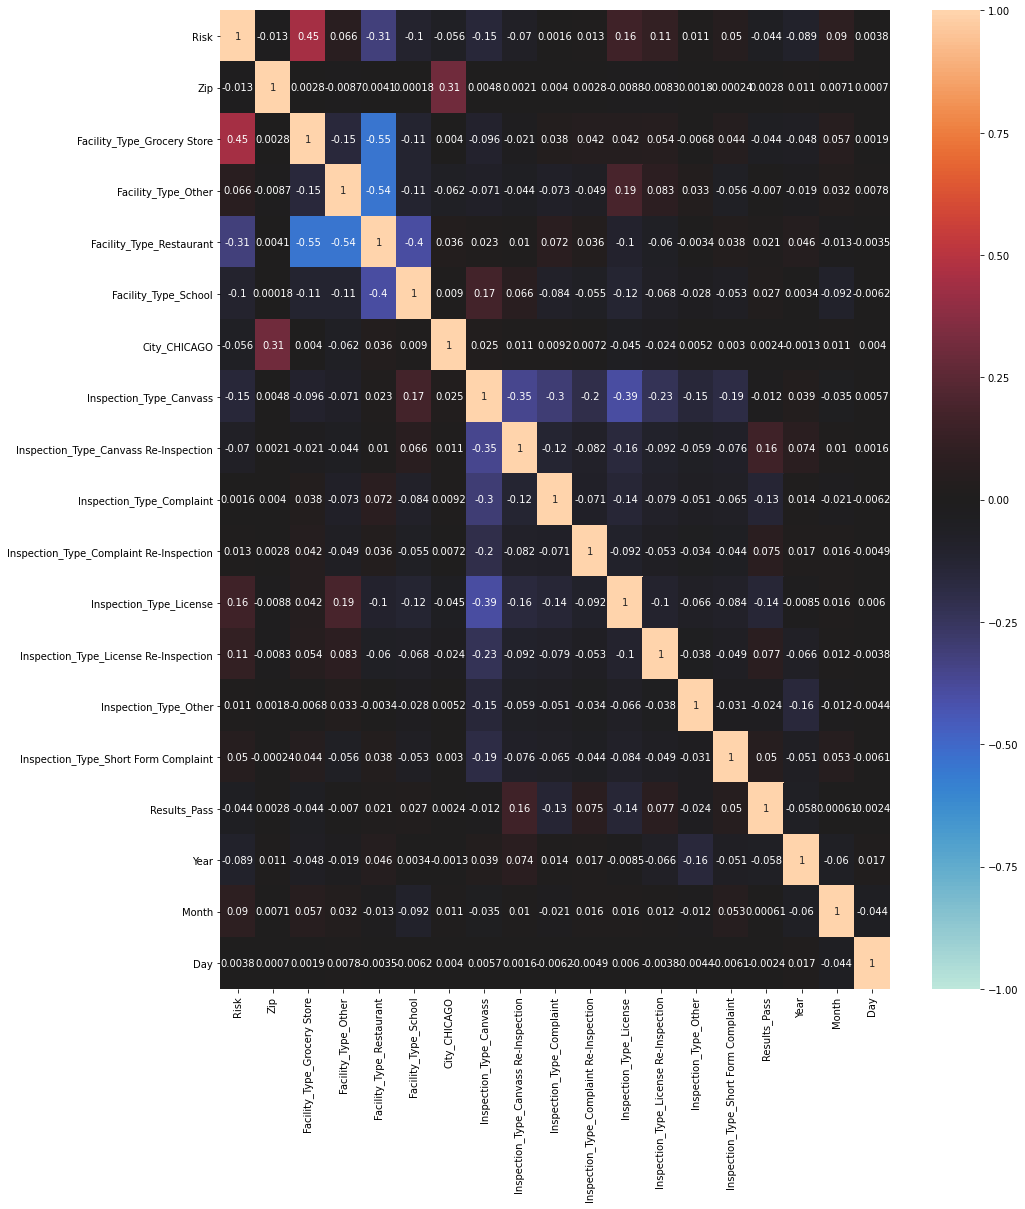

In [ ]:
#import seaborn as sns
fig, ax = plt.subplots(figsize=(15,18))
corr = df_clean.corr()
sns.heatmap(corr, -1, 1, ax=ax, center=0, annot=True);

We want to try to use the Location data to see if there are any trends by neighborhood.  Unfortunately, there does not seem to be much of a trend between the Passed vs Failed inspections and the Location. 

Text(0.5, 1.0, 'Map of Observations')

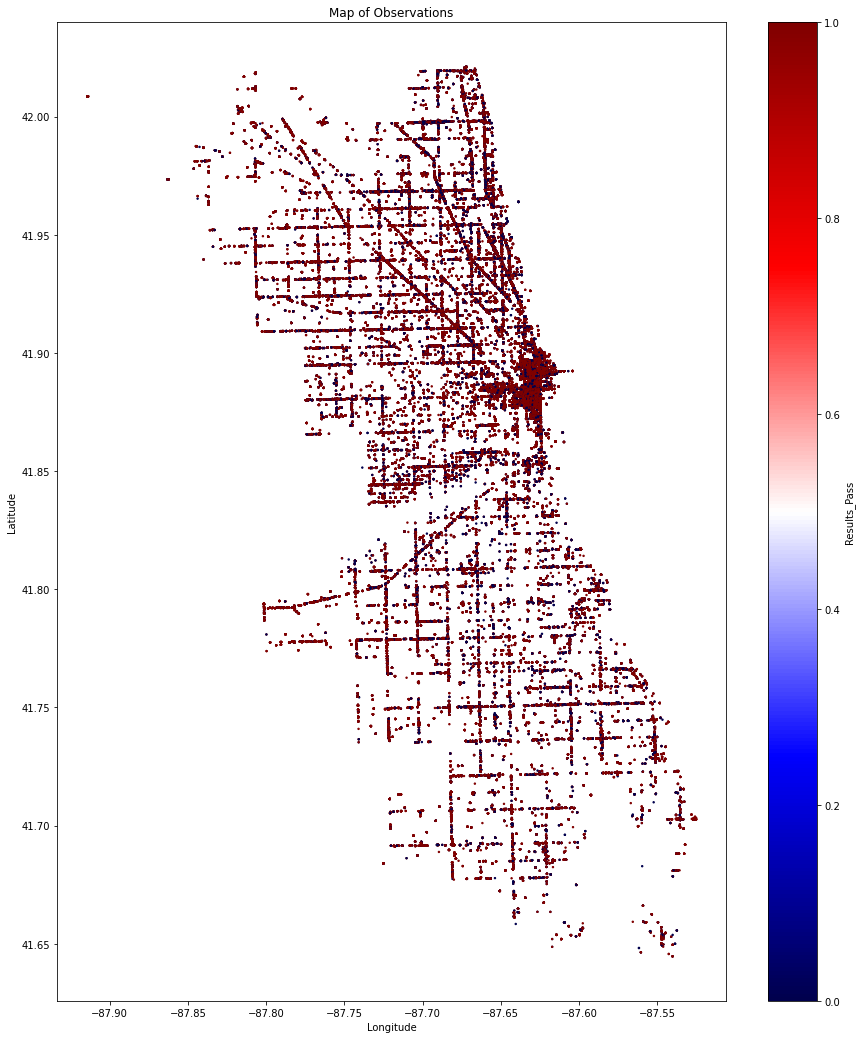

In [ ]:
fig, ax = plt.subplots(figsize=(15,18))

map_df.plot(kind="scatter",
        x="Longitude",
        y="Latitude",
        c="Results_Pass",
        cmap='seismic',
        colorbar=True,
        s=2,
        ax=ax,
        use_index=False,
        alpha=1)

plt.title('Map of Observations')

In [ ]:
# Correlation matrix
df_clean.corr()['Results_Pass'].sort_values(ascending=False)

Results_Pass                               1.000000
Inspection_Type_Canvass Re-Inspection      0.157271
Inspection_Type_License Re-Inspection      0.077353
Inspection_Type_Complaint Re-Inspection    0.075251
Inspection_Type_Short Form Complaint       0.049551
Facility_Type_School                       0.027252
Facility_Type_Restaurant                   0.021214
Zip                                        0.002769
City_CHICAGO                               0.002410
Month                                      0.000608
Day                                       -0.002393
Facility_Type_Other                       -0.007025
Inspection_Type_Canvass                   -0.011547
Inspection_Type_Other                     -0.024466
Risk                                      -0.043596
Facility_Type_Grocery Store               -0.043689
Year                                      -0.057635
Inspection_Type_Complaint                 -0.126252
Inspection_Type_License                   -0.135216
Name: Result

Next, let's see the balance of values for each of the features:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64145bca50>,
      dtype=object)

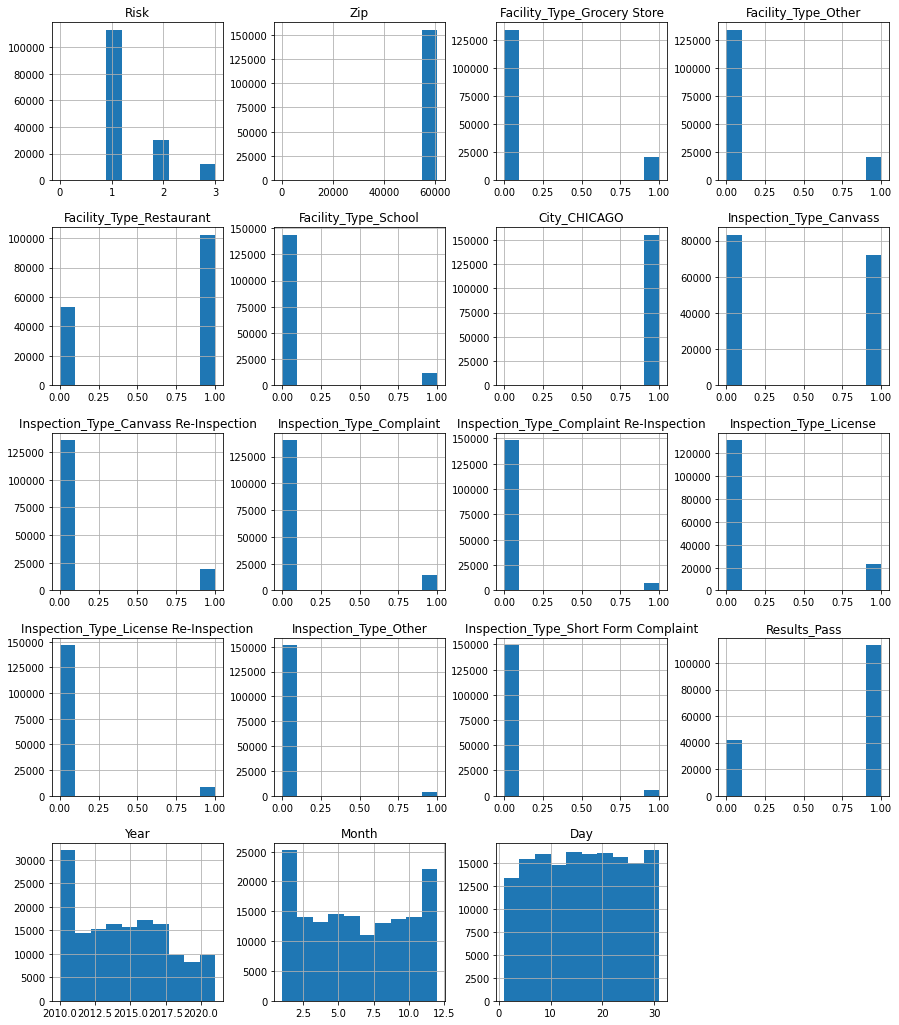

In [ ]:
fig, ax = plt.subplots(figsize=(15,18))
df_clean.hist(ax=ax)

Next, we want to take some of the more interesting features, and get a general feel for how they trend against the Target variable (Inspection Result)

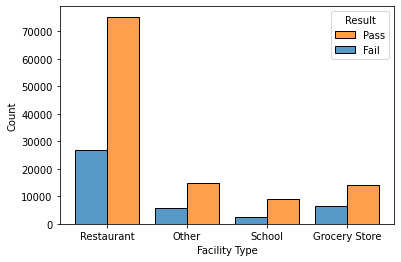

In [ ]:
df_boxplot = df_categorical[['Facility_Type', 'Results_Pass']].copy()
sns.histplot(data=df_boxplot, x="Facility_Type", hue="Results_Pass", multiple="dodge", shrink=.8)
plt.xlabel('Facility Type')
plt.legend(title='Result', loc='upper right', labels=['Pass', 'Fail'])

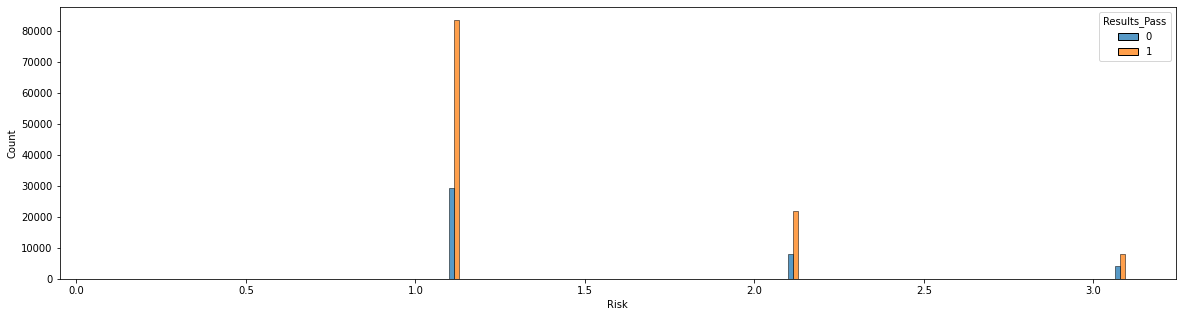

In [ ]:
df_boxplot = df_categorical[['Risk', 'Results_Pass']].copy()
df_boxplot['Risk'] = df['Risk'].fillna('NoValue')

plt.figure(figsize=(20,5))
sns.histplot(data=df_boxplot, x="Risk", hue="Results_Pass", multiple="dodge", shrink=.8)

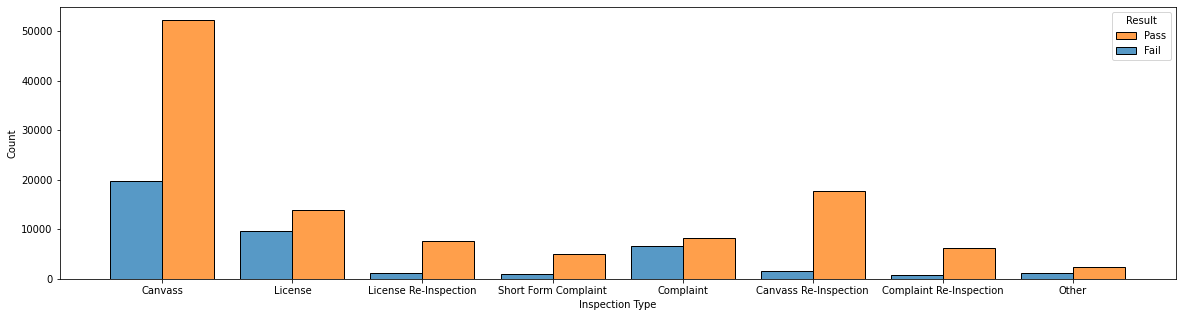

In [ ]:
df_boxplot = df_categorical[['Inspection_Type', 'Results_Pass']].copy()
plt.figure(figsize=(20,5))
ax = sns.histplot(data=df_boxplot, x="Inspection_Type", hue="Results_Pass", multiple="dodge", shrink=.8)
plt.xlabel('Inspection Type')
plt.legend(title='Result', labels=['Pass', 'Fail'])

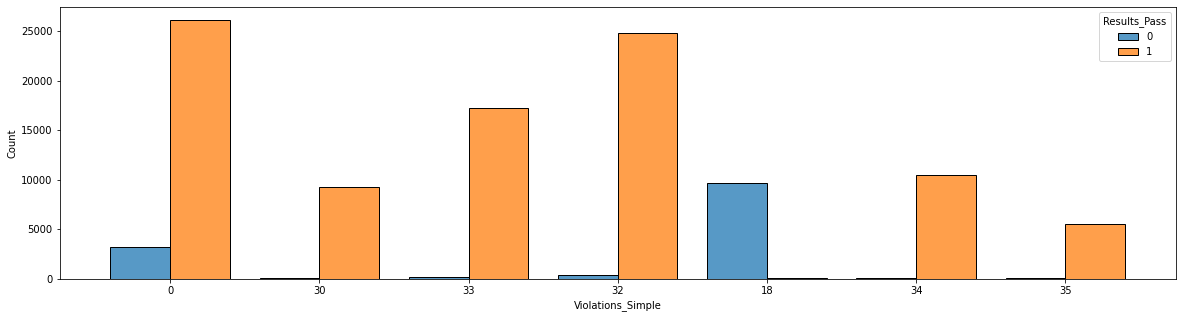

In [ ]:
df_boxplot = df_categorical[['Violations_Simple', 'Results_Pass']].copy()
df_boxplot = df_boxplot.groupby("Violations_Simple").filter(lambda x: len(x) > 5000)
plt.figure(figsize=(20,5))
ax = sns.histplot(data=df_boxplot, x="Violations_Simple", hue="Results_Pass", multiple="dodge", shrink=.8)
ax

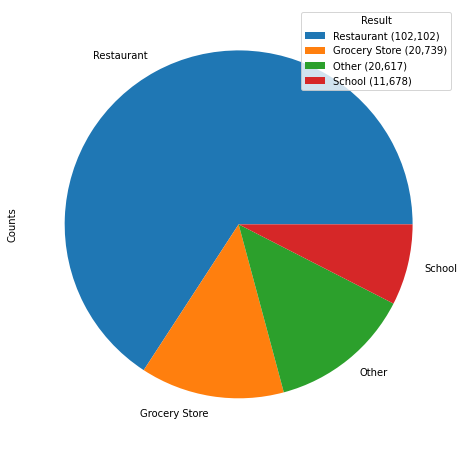

In [ ]:
df_pie = pd.DataFrame({'Counts': df_categorical['Facility_Type'].value_counts()})
fig, ax = plt.subplots(figsize=(8, 8))
df_pie.plot(kind='pie', y='Counts', ax=ax)
plt.legend(title='Result', loc='upper right', labels=['Restaurant (102,102)', 'Grocery Store (20,739)', 'Other (20,617)', 'School (11,678)'])

We want to take a deeper dive into the Violations field.  Let's try to get a feel for the most commonly assigned Violations, and how many of those lead to Failed inspections:

[Text(0, 0, 'PHYSICAL FACILITIES\nINSTALLED,\nMAINTAINED & CLEAN'),
 Text(0, 0, 'NO EVIDENCE OF\nRODENT OR INSECT\nOUTER OPENINGS\nPROTECTED/RODENT\nPROOFED, A WRITTEN\nLOG SHALL BE\nMAINTAINED AVAILABLE\nTO THE INSPECTORS'),
 Text(0, 0, 'FOOD IN ORIGINAL\nCONTAINER, PROPERLY\nLABELED: CUSTOMER\nADVISORY POSTED AS\nNEEDED'),
 Text(0, 0, 'FOOD AND NON-FOOD\nCONTACT SURFACES\nPROPERLY DESIGNED,\nCONSTRUCTED AND\nMAINTAINED'),
 Text(0, 0, 'FOOD AND NON-FOOD\nCONTACT EQUIPMENT\nUTENSILS CLEAN, FREE\nOF ABRASIVE\nDETERGENTS'),
 Text(0, 0, 'FLOORS: CONSTRUCTED\nPER CODE, CLEANED,\nGOOD REPAIR, COVING\nINSTALLED, DUST-LESS\nCLEANING METHODS\nUSED'),
 Text(0, 0, 'WALLS, CEILINGS,\nATTACHED EQUIPMENT\nCONSTRUCTED PER\nCODE: GOOD REPAIR,\nSURFACES CLEAN AND\nDUST-LESS CLEANING\nMETHODS'),
 Text(0, 0, 'LIGHTING: REQUIRED\nMINIMUM FOOT-CANDLES\nOF LIGHT PROVIDED,\nFIXTURES SHIELDED'),
 Text(0, 0, 'VENTILATION: ROOMS\nAND EQUIPMENT VENTED\nAS REQUIRED:\nPLUMBING: INSTALLED\nAND MAINTAINED'),
 Text(

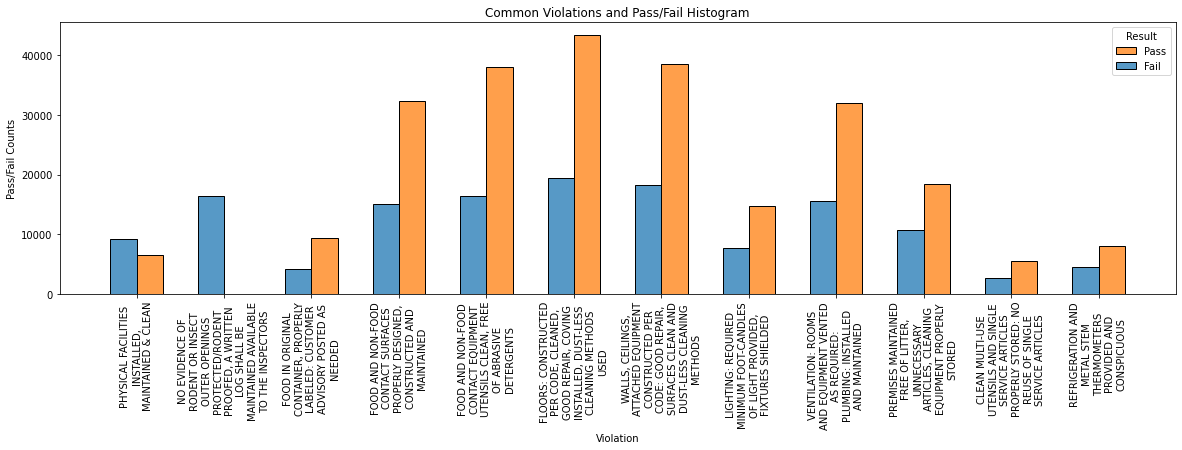

In [ ]:
import textwrap

plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
ax = sns.histplot(data=df_violations_exploded, x='Violations_Split', hue="Results_Pass", multiple="dodge", shrink=.6)

max_width = 20

plt.title('Common Violations and Pass/Fail Histogram')
plt.ylabel('Pass/Fail Counts')
plt.xlabel('Violation')
plt.legend(title='Result', labels=['Pass', 'Fail'])

ax.set_xticklabels(textwrap.fill(x, max_width) for x in df_violations_exploded['Violations_Split'].unique())

We see here two common violations with a higher fail rate than pass rate: evidence of protection and logging of rodents and physical facilities install, maintainced, and cleaned.

In [ ]:
df_violations_extended['Results_Sum'] = df_violations_extended[['Violations_Split', 'Results_Pass']].groupby(['Violations_Split'])['Results_Pass'].transform('sum')
df_violations_extended['Results_Count'] = df_violations_extended[['Violations_Split', 'Results_Pass']].groupby(['Violations_Split'])['Results_Pass'].transform('count')
df_violations_extended['Results_Perc'] = df_violations_extended['Results_Sum'] / df_violations_extended['Results_Count']

In [ ]:
# Get the violations with frequency greater than 0.5% with the lowest pass rates
extended_frequent_violations = df_violations_extended['Violations_Split'].value_counts(normalize=True).loc[lambda x : x>0.005].index.tolist()
df_violations_passrate = df_violations_extended[df_violations_extended['Violations_Split'].isin(extended_frequent_violations)] \
  [['Violations_Split', 'Results_Perc', 'Results_Count']] \
  .drop_duplicates() \
  .sort_values('Results_Perc', ascending=True)

In [ ]:
df_violations_passrate

,Violations_Split,Results_Perc,Results_Count
953,OUTSIDE GARBAGE WASTE GREASE AND STORAGE AREA;...,0.003333,3900
904,PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42-0,0.005378,5578
904,NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS...,0.005568,16524
915,POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATURE R...,0.005717,3673
904,"FOOD PROTECTED DURING STORAGE, PREPARATION, DI...",0.007690,3771
904,* CERTIFIED FOOD MANAGER ON SITE WHEN POTENTIA...,0.010241,4101
29,"MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPL...",0.011128,3954
37,NO CITATION ISSUED.,0.014638,3484
29,PROCEDURES FOR RESPONDING TO VOMITING AND DIAR...,0.014905,4428
915,FACILITIES TO MAINTAIN PROPER TEMPERATURE,0.017442,3612


[Text(0, 0, 'OUTSIDE GARBAGE\nWASTE GREASE AND\nSTORAGE AREA; CLEAN,\nRODENT PROOF, ALL\nCONTAINERS COVERED'),
 Text(0, 0, 'PREVIOUS MINOR\nVIOLATION(S)\nCORRECTED 7-42-0'),
 Text(0, 0, 'NO EVIDENCE OF\nRODENT OR INSECT\nOUTER OPENINGS\nPROTECTED/RODENT\nPROOFED, A WRITTEN\nLOG SHALL BE\nMAINTAINED AVAILABLE\nTO THE INSPECTORS'),
 Text(0, 0, 'POTENTIALLY\nHAZARDOUS FOOD MEETS\nTEMPERATURE\nREQUIREMENT DURING\nSTORAGE, PREPARATION\nDISPLAY AND SERVICE'),
 Text(0, 0, 'FOOD PROTECTED\nDURING STORAGE,\nPREPARATION,\nDISPLAY, SERVICE AND\nTRANSPORTATION'),
 Text(0, 0, '* CERTIFIED FOOD\nMANAGER ON SITE WHEN\nPOTENTIALLY\nHAZARDOUS FOODS ARE\nPREPARED AND SERVED'),
 Text(0, 0, 'MANAGEMENT, FOOD\nEMPLOYEE AND\nCONDITIONAL\nEMPLOYEE; KNOWLEDGE,\nRESPONSIBILITIES AND\nREPORTING'),
 Text(0, 0, 'NO CITATION ISSUED.'),
 Text(0, 0, 'PROCEDURES FOR\nRESPONDING TO\nVOMITING AND\nDIARRHEAL EVENTS'),
 Text(0, 0, 'FACILITIES TO\nMAINTAIN PROPER\nTEMPERATURE'),
 Text(0, 0, 'INSECTS, RODENTS, &\nANIMALS N

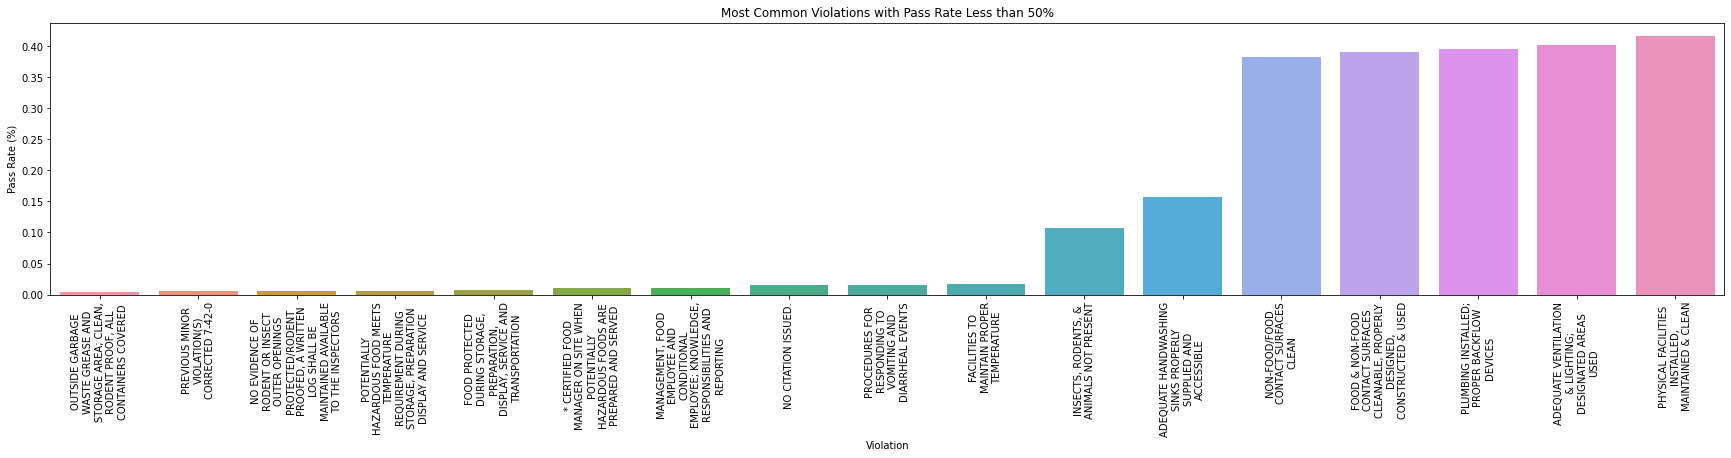

In [ ]:
import textwrap

plt.figure(figsize=(30,5))
plt.xticks(rotation=90)

# Max width: https://stackoverflow.com/questions/57144682/split-string-xticks-into-multiple-lines-matplotlib
max_width = 20
ax = sns.barplot(data=df_violations_passrate[df_violations_passrate['Results_Perc'] < 0.5], x='Violations_Split', y="Results_Perc")

plt.title('Most Common Violations with Pass Rate Less than 50%')
plt.ylabel('Pass Rate (%)')
plt.xlabel('Violation')
ax.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels())

## **Models**

### Metric Functions

Now that we have a general idea for what the data looks like, let's try running some machine learning models against the data to see if we can predict when inspections will Pass or Fail:

In [ ]:
# Classification matrix
def classification_report(actual, predicted):
  from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
  import seaborn as sns

  print(classification_report(actual, predicted))
  cm = confusion_matrix(actual, predicted)

  sns.heatmap(cm, annot=True, fmt='g')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

def metrics(actual, predicted):
  from sklearn.metrics import \
    average_precision_score, precision_recall_curve, roc_curve, recall_score, \
    precision_score, accuracy_score, mean_squared_error, r2_score
  import numpy as np

  # Precision, recall, accuracy
  average_precision = average_precision_score(actual, predicted)
  precision = precision_score(actual, predicted)
  recall = recall_score(actual, predicted)
  accuracy = accuracy_score(actual, predicted)

  print('Precision score: %.3f' % precision)
  print('Recall score: %.3f' % recall)
  print('Accuracy score: %.3f' % accuracy)
  print('\n Average precision score: %.3f' % average_precision)

  # Error
  print("\nMean squared error: %.2f" \
        % mean_squared_error(actual, predicted))
  
  print("Root mean squared error: %.2f" % \
        (np.sqrt( mean_squared_error(actual, predicted))) )
  
  print("Mean of target variable: %.3f" % (actual.mean()))
  
  print("RMSE percentage of mean: %.3f" \
        % (100 * np.sqrt( mean_squared_error(actual, predicted)) / actual.mean()))

# https://stackoverflow.com/questions/42128545/how-to-print-the-order-of-important-features-in-random-forest-regression-using-p
def display_rf_feature_importance(columns, rf):
  featureImp = []
  for feat, importance in zip(columns, rf.feature_importances_):  
      temp = [feat, importance*100]
      featureImp.append(temp)

  fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
  print(fT_df.sort_values('Importance', ascending = False))

# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
def display_log_reg_coeff(columns, log_reg):
  df_col = pd.DataFrame( data = np.asarray(columns)  )
  df_coef = pd.DataFrame( data = log_reg.coef_[0])
  df_tbl =  pd.concat ( [df_col, df_coef] , axis = 1 )
  df_tbl.columns = [' Model Variable', 'Coefficients']
  return df_tbl.reindex(df_tbl.Coefficients.abs().sort_values(ascending=False).index).reset_index()

In [ ]:
# Test splits
from sklearn.model_selection import train_test_split

X_train_violations, X_test_violations, y_train_violations, y_test_violations = train_test_split(df_violations_onehot.drop('Results_Pass', axis=1), df_violations_onehot['Results_Pass'], test_size=0.3, random_state=0)

### Logistic Regression

The 1st model we want to try is Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


              precision    recall  f1-score   support

           0       0.78      0.18      0.29     42014
           1       0.68      0.97      0.80     74136

    accuracy                           0.69    116150
   macro avg       0.73      0.58      0.55    116150
weighted avg       0.72      0.69      0.62    116150



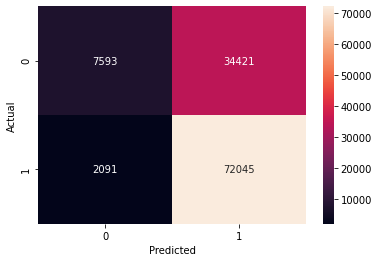

Precision score: 0.677
Recall score: 0.972
Accuracy score: 0.686

 Average precision score: 0.676

Mean squared error: 0.31
Root mean squared error: 0.56
Mean of target variable: 0.638
RMSE percentage of mean: 87.841


In [ ]:
from imblearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression

log_reg_violations = Pipeline(
  [
   ('Logistic Regression', LogisticRegression(n_jobs=-1))
  ]
)

# Fit pipeline
log_reg_violations.fit(X_train_violations, y_train_violations) 
predicted = log_reg_violations.predict(X_test_violations)

# Print results
classification_report(y_test_violations, predicted)
metrics(y_test_violations, predicted)

Basic Logistic Regression seems to have mixed results.  Even though the Recall is very good (0.972), the overall Accuracy score is fairly weak (0.686).


              precision    recall  f1-score   support

           0       0.78      0.18      0.29     42014
           1       0.68      0.97      0.80     74136

    accuracy                           0.69    116150
   macro avg       0.73      0.58      0.55    116150
weighted avg       0.72      0.69      0.62    116150



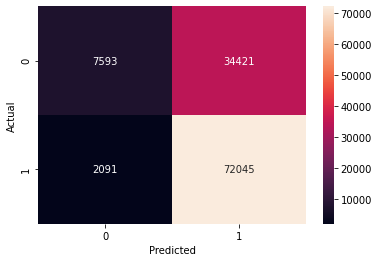

Precision score: 0.677
Recall score: 0.972
Accuracy score: 0.686

 Average precision score: 0.676

Mean squared error: 0.31
Root mean squared error: 0.56
Mean of target variable: 0.638
RMSE percentage of mean: 87.841
                                              Feature  Importance
6   Violations_Split_NO EVIDENCE OF RODENT OR INSE...   80.119489
7   Violations_Split_PHYSICAL FACILITIES INSTALLED...   10.142886
2   Violations_Split_FOOD AND NON-FOOD CONTACT EQU...    1.685018
1   Violations_Split_FLOORS: CONSTRUCTED PER CODE,...    1.597983
10  Violations_Split_VENTILATION: ROOMS AND EQUIPM...    1.538293
11  Violations_Split_WALLS, CEILINGS, ATTACHED EQU...    0.983748
3   Violations_Split_FOOD AND NON-FOOD CONTACT SUR...    0.892204
8   Violations_Split_PREMISES MAINTAINED FREE OF L...    0.829675
4   Violations_Split_FOOD IN ORIGINAL CONTAINER, P...    0.746162
9   Violations_Split_REFRIGERATION AND METAL STEM ...    0.713415
5   Violations_Split_LIGHTING: REQUIRED MINIMUM FO...    

In [ ]:
from imblearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier

rf_violations = RandomForestClassifier(random_state=0)

# Fit pipeline
rf_violations.fit(X_train_violations, y_train_violations) 
predicted = rf_violations.predict(X_test_violations)

# Print results
classification_report(y_test_violations, predicted)
metrics(y_test_violations, predicted)
display_rf_feature_importance(X_train_violations.columns, rf_violations)

Random Forest seems to have very similar results to Logistic Regression

We do know that the Target Variable is imbalanced, so let's try to adjust for that by using SMOTE

In [ ]:
# Test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_clean.drop(['Results_Pass', 'Zip'], axis=1), df_clean['Results_Pass'], test_size=0.3, random_state=0)

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline(
  [
    ('SMOTE', SMOTE()),
    ('Logistic Regression', LogisticRegression(n_jobs=-1))
  ]
)

In [ ]:
# Fit pipeline
log_reg.fit(X_train, y_train) 
predicted = log_reg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.65      0.80      0.71     12509
           1       0.92      0.84      0.88     34032

    accuracy                           0.83     46541
   macro avg       0.78      0.82      0.80     46541
weighted avg       0.84      0.83      0.83     46541



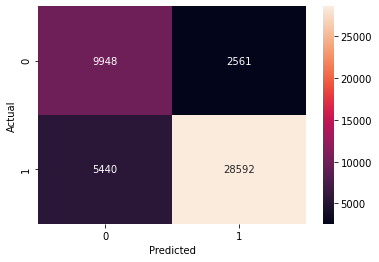

Precision score: 0.918
Recall score: 0.840
Accuracy score: 0.828

 Average precision score: 0.888

Mean squared error: 0.17
Root mean squared error: 0.41
Mean of target variable: 0.731
RMSE percentage of mean: 56.703


In [ ]:
# Print results
classification_report(y_test, predicted)
metrics(y_test, predicted)

These results are looking much better!

In [ ]:
# Print the coefficients with the greatest magnitude
display_log_reg_coeff(X_train.columns, log_reg.named_steps['Logistic Regression']).head(10)

,index,Model Variable,Coefficients
0,8,Inspection_Type_Canvass Re-Inspection,1.489724
1,9,Inspection_Type_Complaint,-1.332774
2,7,Inspection_Type_Canvass,-1.155900
3,12,Inspection_Type_License Re-Inspection,0.988214
4,11,Inspection_Type_License,-0.921567
5,10,Inspection_Type_Complaint Re-Inspection,0.574840
6,14,Inspection_Type_Short Form Complaint,0.364698
7,2,Facility_Type_Grocery Store,-0.279429
8,3,Facility_Type_Other,0.180266
9,0,Risk,-0.115241


Text(0.5, 1.0, 'Coefficients for Logisitc Regression Model')

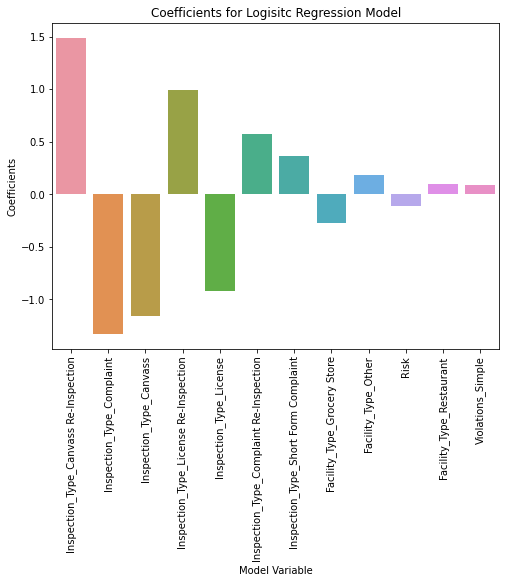

In [ ]:
df_col = pd.DataFrame( data = np.asarray(X_train.columns)  )
df_coef = pd.DataFrame( data = log_reg.named_steps['Logistic Regression'].coef_[0])
df_tbl =  pd.concat ( [df_col, df_coef] , axis = 1 )
df_tbl.columns = ['Model Variable', 'Coefficients']
df_tbl = df_tbl.reindex(df_tbl.Coefficients.abs().sort_values(ascending=False).index).reset_index()

fig, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=90)

ax = sns.barplot(data=df_tbl.iloc[0:12,:], x='Model Variable', y='Coefficients', )
plt.title('Coefficients for Logisitc Regression Model')

In [ ]:
import statsmodels.api as sm

# Investigate factors not contributing to model
sm_X_train = sm.add_constant(X_train)

lm = sm.OLS(y_train.astype(float), sm_X_train.astype(float)).fit()
lm.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Results_Pass   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     2060.
Date:                Sun, 28 Feb 2021   Prob (F-statistic):               0.00
Time:                        05:17:03   Log-Likelihood:                -51467.
No. Observations:              108595   AIC:                         1.030e+05
Df Residuals:                  108578   BIC:                         1.031e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      16.4041      0.592     27.713      0.000      15.244      17.564
Risk                                        0.0032      0.002      1.470      0.142      -0.001       0.008
Violations_Simple                           0.0124   8.22e-05    150.759      0.000       0.012       0.013
Facility_Type_Grocery Store                 4.0638      0.148     27.455      0.000       3.774       4.354
Facility_Type_Other                         4.1246      0.148     27.864      0.000       3.834       4.415
Facility_Type_Restaurant                    4.1165      0.148     27.807      0.000       3.826       4.407
Facility_Type_School                        4.0991      0.148     27.706      0.000       3.809       4.389
City_CHICAGO                               -0.0685      0.029     -2.333      0.020      -0.126      -0.011
Inspection_Type_Canvass                     1.9364      0.074     26.087      0.000       1.791       2.082
Inspection_Type_Canvass Re-Inspection       2.1885      0.074     29.389      0.000       2.043       2.334
Inspection_Type_Complaint                   1.8137      0.074     24.418      0.000       1.668       1.959
Inspection_Type_Complaint Re-Inspection     2.1775      0.074     29.253      0.000       2.032       2.323
Inspection_Type_License                     1.9326      0.074     26.035      0.000       1.787       2.078
Inspection_Type_License Re-Inspection       2.2529      0.074     30.435      0.000       2.108       2.398
Inspection_Type_Other                       1.9747      0.073     26.943      0.000       1.831       2.118
Inspection_Type_Short Form Complaint        2.1276      0.074     28.718      0.000       1.982       2.273
Year                                       -0.0109      0.000    -27.038      0.000      -0.012      -0.010
Month                                      -0.0005      0.000     -1.542      0.123      -0.001       0.000
Day                                     -9.827e-05      0.000     -0.713      0.476      -0.000       0.000
==============================================================================
Omnibus:                     7813.892   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8267.677
Skew:                          -0.636   Prob(JB):                         0.00
Kurtosis:                       2.544   Cond. No.                     1.55e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.82e-27. This might indicate that there are
strong multicollinearity problems or that the design m

**Automatic Feature Elimination**

Let's try to further improving the model by introducing Feature Elimination

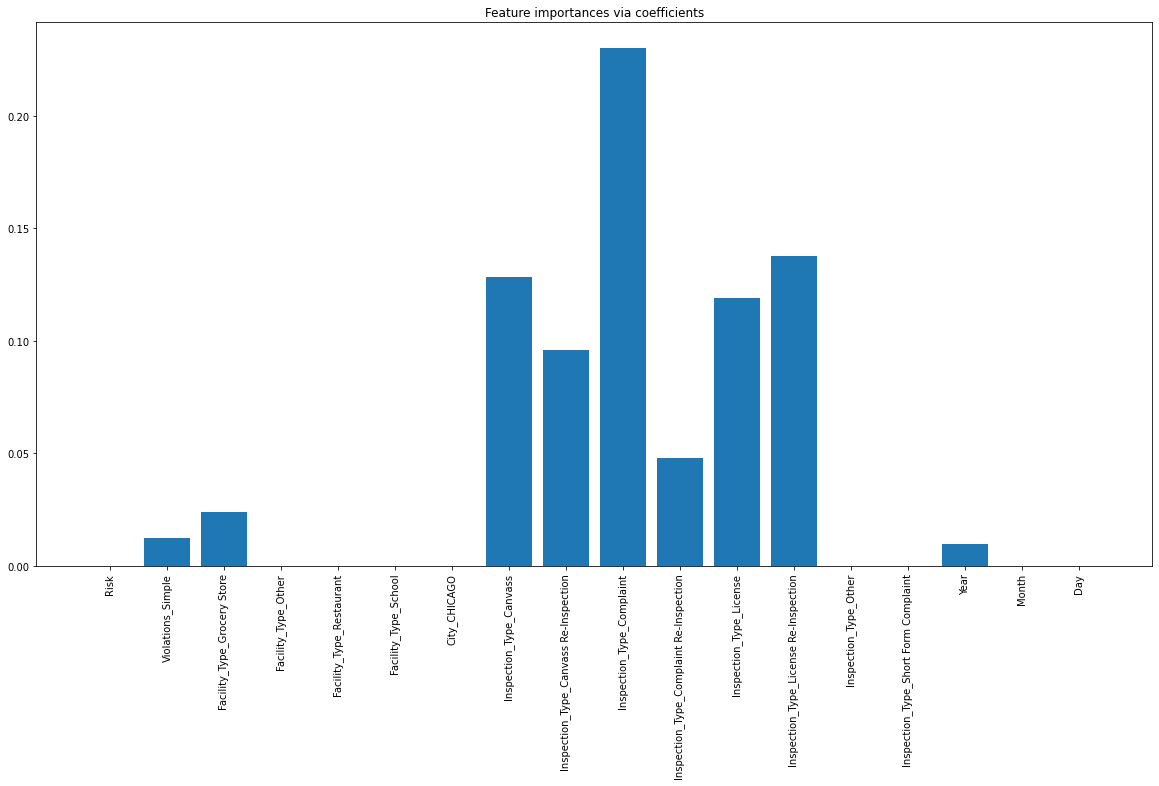

In [ ]:
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html
import numpy as np
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(X_train, y_train)

importance = np.abs(lasso.coef_)
feature_names = np.array(df_clean.drop('Results_Pass', axis=1).columns)

fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=90)
plt.bar(height=importance, x=X_train.columns)
plt.title("Feature importances via coefficients")
plt.show()

In [ ]:
selected_columns = [
  'Inspection_Type_Complaint',
  'Inspection_Type_Canvass',
  'Inspection_Type_Canvass Re-Inspection',
  'Inspection_Type_License',
  'Inspection_Type_License Re-Inspection'
]

# Fit pipeline
log_reg.fit(X_train[selected_columns], y_train) 
predicted = log_reg.predict(X_test[selected_columns])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.32      0.86      0.47     12509
           1       0.87      0.34      0.49     34032

    accuracy                           0.48     46541
   macro avg       0.60      0.60      0.48     46541
weighted avg       0.72      0.48      0.48     46541



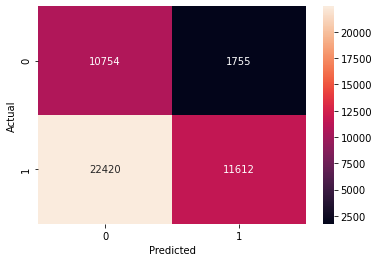

Precision score: 0.869
Recall score: 0.341
Accuracy score: 0.481

 Average precision score: 0.778

Mean squared error: 0.52
Root mean squared error: 0.72
Mean of target variable: 0.731
RMSE percentage of mean: 98.563


In [ ]:
# Print results
classification_report(y_test, predicted)
metrics(y_test, predicted)

This is very interesting, but the model appears to be getting much worse when removing features.

**PCA Selection**

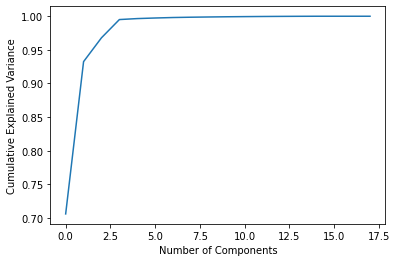

In [ ]:
from sklearn.decomposition import PCA

# Run PCA to find the ideal number of components
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

In [ ]:
# Find the number of components needed to explain 90% of the variance in the dataset
pca = PCA(0.90).fit(X_train)
pca.n_components_

2

In [ ]:
from sklearn.decomposition import PCA

# Create a logistic regression pipeline with SMOTE resampling and PCA
log_reg = Pipeline(
  [
    ('SMOTE', SMOTE()),
    ('PCA', PCA(n_components=pca.n_components_)),
    ('Logistic Regression', LogisticRegression(n_jobs=-1))
  ]
)

In [ ]:
# Fit pipeline
log_reg.fit(X_train, y_train)
predicted = log_reg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.56      0.84      0.67     12509
           1       0.93      0.76      0.84     34032

    accuracy                           0.78     46541
   macro avg       0.75      0.80      0.75     46541
weighted avg       0.83      0.78      0.79     46541



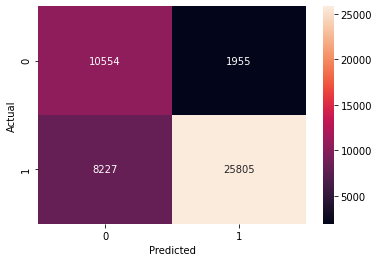

Precision score: 0.930
Recall score: 0.758
Accuracy score: 0.781

 Average precision score: 0.882

Mean squared error: 0.22
Root mean squared error: 0.47
Mean of target variable: 0.731
RMSE percentage of mean: 63.966


In [ ]:
# Print results
classification_report(y_test, predicted)
metrics(y_test, predicted)

**Hyperparameter Tuning**

Hyperparameter Tuning is another way to try to improve the model.  Let's see if it shows any positive results

In [ ]:
# Using article as guide for model practices: https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b
# Model parameters: https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5
from sklearn.model_selection import GridSearchCV

# Define the Logistic Regression model with weights
n_components = list(range(1,X_train.shape[1]+1,1))
param_grid = [
    {
      'max_iter': [50, 100, 500, 1000],
      'penalty': ['l1','l2'],
      'C': [0.001,0.01,0.1,1,10,100,1000]
    }
]

lr_grid = Pipeline(
  [
   ('SMOTE', SMOTE()),
   ('Scaler', StandardScaler()),
   ('Logistic Regression', GridSearchCV(
       LogisticRegression(n_jobs=-1), param_grid=param_grid, cv=5, verbose=True, n_jobs=-1))
  ]
)

# Fit the model to our training data and obtain best parameters
lr_grid.fit(X_train, y_train)
predicted = log_reg.predict(X_test)

optimal_weights = lr_grid.named_steps['Logistic Regression'].best_params_

print(f'Best score: {lr_grid.named_steps["Logistic Regression"].best_score_} with param: {lr_grid.named_steps["Logistic Regression"].best_params_}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   25.1s finished


Best score: 0.8343084016227007 with param: {'C': 1, 'max_iter': 50, 'penalty': 'l2'}


              precision    recall  f1-score   support

           0       0.56      0.84      0.67     12509
           1       0.93      0.76      0.84     34032

    accuracy                           0.78     46541
   macro avg       0.75      0.80      0.75     46541
weighted avg       0.83      0.78      0.79     46541



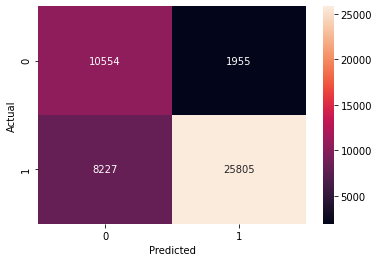

Precision score: 0.930
Recall score: 0.758
Accuracy score: 0.781

 Average precision score: 0.882

Mean squared error: 0.22
Root mean squared error: 0.47
Mean of target variable: 0.731
RMSE percentage of mean: 63.966


In [ ]:
# Print results
classification_report(y_test, predicted)
metrics(y_test, predicted)

### Random Forest


Let's dive deeper into the Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [ ]:
# Fit pipeline
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred=rf.predict(X_test)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     12509
           1       0.97      0.98      0.97     34032

    accuracy                           0.96     46541
   macro avg       0.95      0.95      0.95     46541
weighted avg       0.96      0.96      0.96     46541



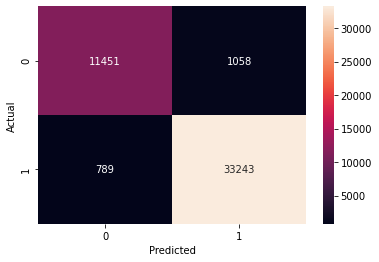

Precision score: 0.969
Recall score: 0.977
Accuracy score: 0.960

 Average precision score: 0.964

Mean squared error: 0.04
Root mean squared error: 0.20
Mean of target variable: 0.731
RMSE percentage of mean: 27.244


In [ ]:
# Print results
classification_report(y_test, y_pred)
metrics(y_test, y_pred)

Random Forest has excellent results, with Precision, Recall, and Accuracy all over 0.95!

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

clf = LassoCV(cv=5, max_iter=100000, tol=0.1)
sel = SelectFromModel(clf, threshold=0.01)
X_train_sel = sel.fit_transform(X_train, y_train)

In [ ]:
selected_feat = X_train.columns[(sel.get_support())]
len(selected_feat)
print(selected_feat)

Index(['Violations_Simple', 'Facility_Type_Grocery Store',
       'Inspection_Type_Canvass', 'Inspection_Type_Canvass Re-Inspection',
       'Inspection_Type_Complaint', 'Inspection_Type_Complaint Re-Inspection',
       'Inspection_Type_License', 'Inspection_Type_License Re-Inspection',
       'Inspection_Type_Short Form Complaint', 'Year'],
      dtype='object')


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf2 = RandomForestClassifier(n_estimators = pca.n_components_)
rf2.fit(X_train_sel, y_train)
y_pred=rf2.predict(X_test[selected_feat])

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     12509
           1       0.96      0.98      0.97     34032

    accuracy                           0.96     46541
   macro avg       0.95      0.94      0.95     46541
weighted avg       0.96      0.96      0.96     46541



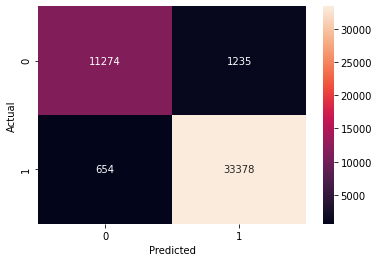

Precision score: 0.964
Recall score: 0.981
Accuracy score: 0.959

 Average precision score: 0.960

Mean squared error: 0.04
Root mean squared error: 0.20
Mean of target variable: 0.731
RMSE percentage of mean: 27.552


In [ ]:
# Print results
classification_report(y_test, y_pred)
metrics(y_test, y_pred)

In [ ]:
# Setup model comparison array
models = [('Random Forest', rf, X_test), ('Random Forest (Selected Features)', rf2, X_test[selected_feat])]

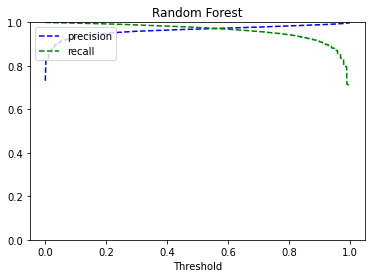

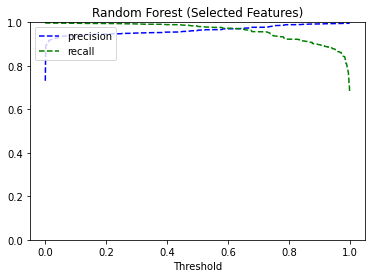

In [ ]:
# Taken from: https://www.kaggle.com/questions-and-answers/39659
from sklearn.metrics import \
  average_precision_score, precision_recall_curve, roc_curve, recall_score

for (title, model, test) in models:
  # Plot the recall precision tradeoff
  predicted=model.predict_proba(test)
  prec, rec, tre = precision_recall_curve(y_test, predicted[:,1], )

  def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
      plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
      plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
      plt.xlabel('Threshold')
      plt.legend(loc='upper left')
      plt.ylim([0,1])

  plt.title(title)
  plot_prec_recall_vs_tresh(prec, rec, tre)
  plt.show()

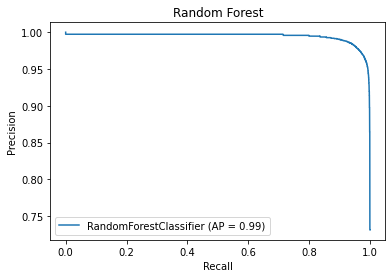

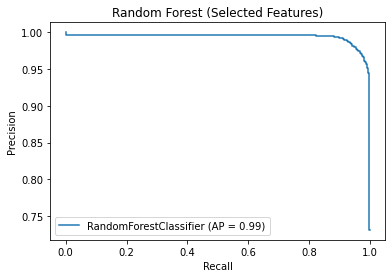

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

for (title, model, test) in models:
  # Plot the Precision Recall Curve
  plot_precision_recall_curve(model, test, y_test)
  plt.title(title)
  plt.show()

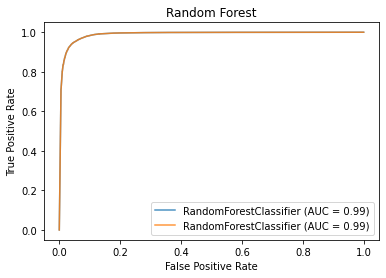

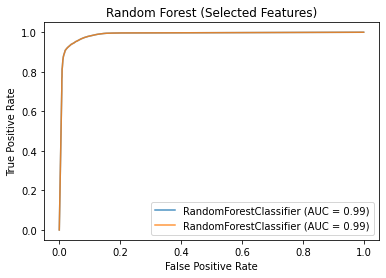

In [ ]:
from sklearn.metrics import plot_roc_curve

for (title, model, test) in models:
  # Plot ROC curve  
  ax = plt.gca()
  rfc_disp = plot_roc_curve(model, test, y_test, ax=ax, alpha=0.8)
  plt.title(title)
  rfc_disp.plot(ax=ax, alpha=0.8)
  plt.show()

In [ ]:
# Display the feature importance
display_rf_feature_importance(X_train,  rf)

                                    Feature  Importance
1                         Violations_Simple   74.256530
17                                      Day    6.001522
15                                     Year    4.835657
16                                    Month    3.562963
7                   Inspection_Type_Canvass    2.198334
8     Inspection_Type_Canvass Re-Inspection    1.854441
11                  Inspection_Type_License    1.491158
9                 Inspection_Type_Complaint    1.487179
12    Inspection_Type_License Re-Inspection    1.372396
0                                      Risk    0.939057
10  Inspection_Type_Complaint Re-Inspection    0.570446
3                       Facility_Type_Other    0.313769
14     Inspection_Type_Short Form Complaint    0.273847
4                  Facility_Type_Restaurant    0.251792
13                    Inspection_Type_Other    0.215501
2               Facility_Type_Grocery Store    0.208921
5                      Facility_Type_School    0

Text(0.5, 1.0, 'Relative Feature Importance for Random Forest Model')

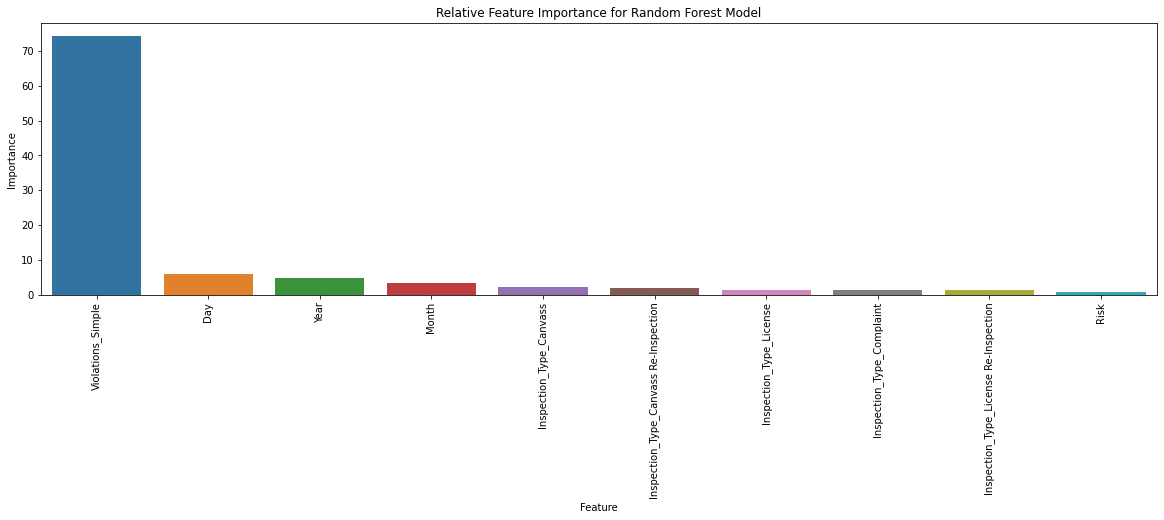

In [ ]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
columns = X_train.columns
featureImp = []
for feat, importance in zip(columns, rf.feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

fT_df = pd.DataFrame(np.asarray(pd.DataFrame(featureImp, columns=["Factor", "Value"]).sort_values('Value', ascending=False).iloc[0:10,:]), columns = ['Feature', 'Importance'])
ax = sns.barplot(data=fT_df.sort_values('Importance', ascending=False), x='Feature', y="Importance")
plt.title("Relative Feature Importance for Random Forest Model")

### K-Means Clustering


In [ ]:
from sklearn.cluster import KMeans

Let's prep our data for clustering by scaling data (saving both the array and dataframe version).  Additionally, 'Zip' does not seem like a good choice for clustering, so let's remove it from the set.

In [ ]:
#prep data for clustering: drop Zip field and scale the data
scaler = StandardScaler()
df_cluster1 = df_clean.copy()
df_cluster1.drop(['Zip'], axis='columns', inplace=True)
cluster_array = scaler.fit_transform(df_cluster1)
df_cluster = pd.DataFrame(cluster_array) #dataframe version of the scaled data
df_cluster.columns = df_cluster1.columns

In order to determine a good choice for the number of clusters, let's try cluster sizes of 1-20 to see what the inertia value for each cluster size is.  From there, we can look for a decent "elbow" to help us choose a cluster size.

Text(0, 0.5, 'Inertia')

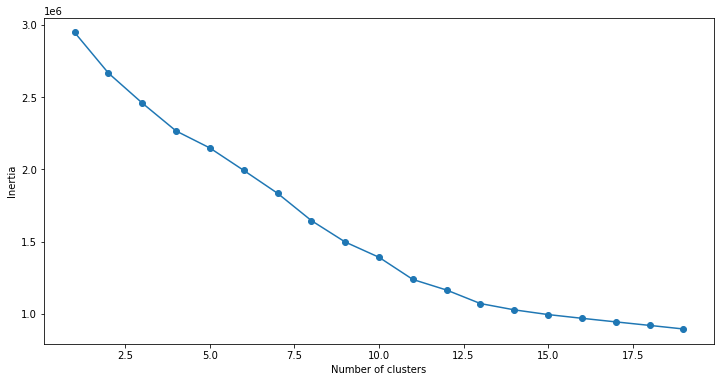

In [ ]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++', random_state=0)
    kmeans.fit(cluster_array)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

There is not an obvious "elbow", so instead let's choose 4 to see if we can get clusters that correspond to the 4 groupings of Facility Type

In [ ]:
# k means using 4 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 4, init='k-means++')
kmeans.fit(clean_scaled)
pred = kmeans.predict(clean_scaled)

Let's label each record in the dataset with it's cluster value, and then do some visual manipulation to try to make sense of trends in the clusters.  First, let's transform the data back to the un-scaled values (for easier interpretation) and see how many records are in each cluster:

In [ ]:
#number of records in each cluster
inversed = scaler.inverse_transform(cluster_array)
frame = pd.DataFrame(inversed)
frame.columns = df_cluster.columns
frame['cluster'] = pred
frame['cluster'].value_counts()

0    66872
3    41361
1    35225
2    11678
Name: cluster, dtype: int64

In [ ]:
cluster0 = frame[frame['cluster'] == 0]
cluster1 = frame[frame['cluster'] == 1]
cluster2 = frame[frame['cluster'] == 2]
cluster3 = frame[frame['cluster'] == 3]

In [ ]:
data = [['cluster0',cluster0['Results_Pass'].mean(), cluster0['Violations_Simple'].value_counts().idxmax()],
        ['cluster1',cluster1['Results_Pass'].mean(), cluster1['Violations_Simple'].value_counts().idxmax()],
        ['cluster2',cluster2['Results_Pass'].mean(), cluster2['Violations_Simple'].value_counts().idxmax()],
        ['cluster3',cluster3['Results_Pass'].mean(), cluster3['Violations_Simple'].value_counts().idxmax()]]

df_clusters = pd.DataFrame(data, columns = ['Cluster_Label', 'Results_Pass_mean', 'Violations_Most_Common']) 
df_clusters.sort_values(by=['Results_Pass_mean'])

,Cluster_Label,Results_Pass_mean,Violations_Most_Common
1,cluster1,0.245962,0.0
3,cluster3,0.701941,0.0
2,cluster2,0.772992,32.0
0,cluster0,0.996247,32.0


In the next section, we've sorted by the cluster most likely to pass an inspection ('Results_Pass' field), and we can look at the mean values of each column to see if there are any trends

In [ ]:
#https://stackoverflow.com/questions/38752444/get-mean-for-all-columns-in-a-dataframe-and-create-a-new-dataframe
df_cluster_means = pd.DataFrame(cluster0.mean().to_dict(),index=['Cluster0Means'])
c1 = pd.DataFrame(cluster1.mean().to_dict(),index=['Cluster1Means'])
c2 = pd.DataFrame(cluster2.mean().to_dict(),index=['Cluster2Means'])
c3 = pd.DataFrame(cluster3.mean().to_dict(),index=['Cluster3Means'])

df_cluster_means = df_cluster_means.append([c1,c2,c3])
df_cluster_means = df_cluster_means[ ['Results_Pass'] + [ col for col in df_cluster_means.columns if col != 'Results_Pass' ] ]
df_cluster_means.sort_values(by=['Results_Pass'])

,Results_Pass,Risk,Violations_Simple,Facility_Type_Grocery Store,Facility_Type_Other,Facility_Type_Restaurant,Facility_Type_School,City_CHICAGO,Inspection_Type_Canvass,Inspection_Type_Canvass Re-Inspection,Inspection_Type_Complaint,Inspection_Type_Complaint Re-Inspection,Inspection_Type_License,Inspection_Type_License Re-Inspection,Inspection_Type_Other,Inspection_Type_Short Form Complaint,Year,Month,Day,cluster
Cluster1Means,0.245962,1.237700,9.347736,0.000000,0.000000,1.000000,0.0,0.999120,0.372179,0.022853,0.144954,0.014507,0.250646,0.097942,0.038666,0.058254,2014.694336,6.456835,15.721987,1.0
Cluster3Means,0.701941,1.755688,20.460990,0.501414,0.498465,0.000121,0.0,0.995310,0.358212,0.097822,0.082251,0.043350,0.257610,0.096395,0.028868,0.035492,2014.278330,6.759919,15.886753,3.0
Cluster2Means,0.772992,1.122196,27.124679,0.000000,0.000000,0.000000,1.0,0.999657,0.768368,0.201490,0.008392,0.004967,0.003939,0.001199,0.008991,0.002655,2014.567991,5.290803,15.592653,2.0
Cluster0Means,0.996247,1.192741,29.851806,0.000000,0.000000,1.000000,0.0,0.999686,0.525736,0.182797,0.092475,0.069536,0.059098,0.018842,0.015358,0.036159,2014.598307,6.286353,15.777605,0.0


In [ ]:
#scale down the Risk field so it makes the plot below easier to look at
df_cluster_means['Risk'] = df_cluster_means['Risk'] / df_cluster_means['Risk'].max()

Text(0, 0.5, 'Mean Occurence')

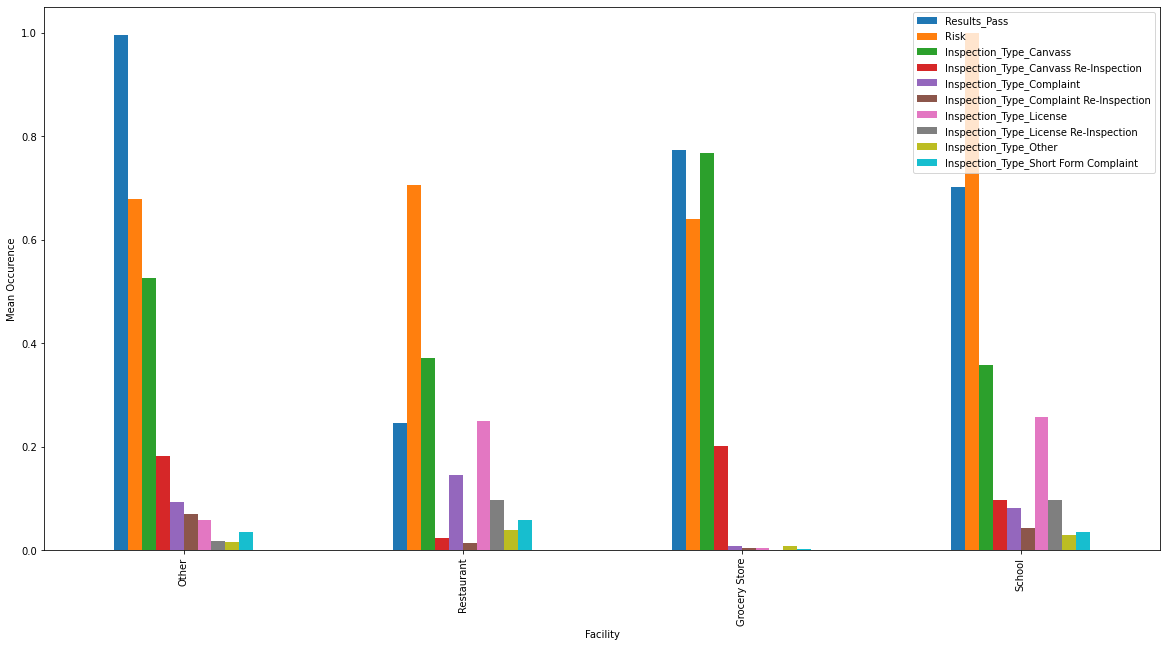

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

columns = ['Results_Pass', 'Risk', 'Inspection_Type_Canvass', 'Inspection_Type_Canvass Re-Inspection', 'Inspection_Type_Complaint', 'Inspection_Type_Complaint Re-Inspection', 'Inspection_Type_License', 'Inspection_Type_License Re-Inspection', 'Inspection_Type_Other', 'Inspection_Type_Short Form Complaint']
df_cluster_means.rename({'Cluster0Means': 'Other', 'Cluster1Means': 'Restaurant', 'Cluster2Means': 'Grocery Store', 'Cluster3Means': 'School'})[columns].plot(kind='bar',ax=ax)
plt.xlabel('Facility')
plt.ylabel('Mean Occurence')

In [ ]:
from matplotlib import rcParams

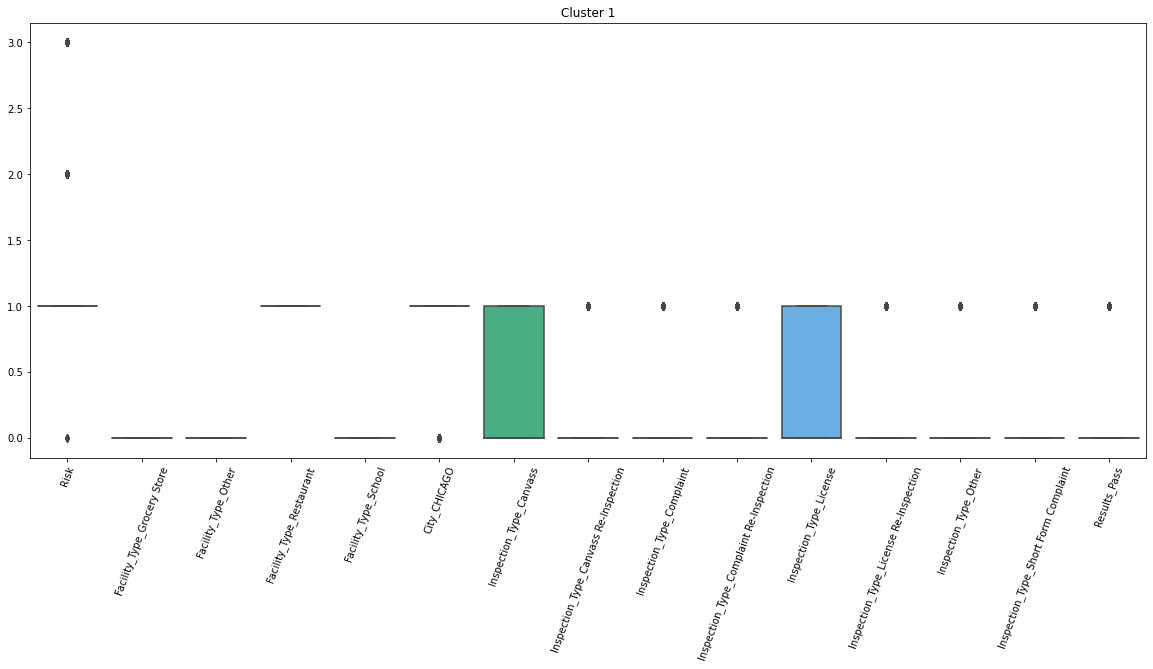

In [ ]:
cluster1bp = cluster1.drop(['Year', 'Month', 'Day', 'Violations_Simple', 'cluster'], axis='columns', inplace=False)
plt.figure(figsize=(20,8))
ax1 = sns.boxplot(data=cluster1bp)
ax1.set_title("Cluster 1")
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=70)
ax1

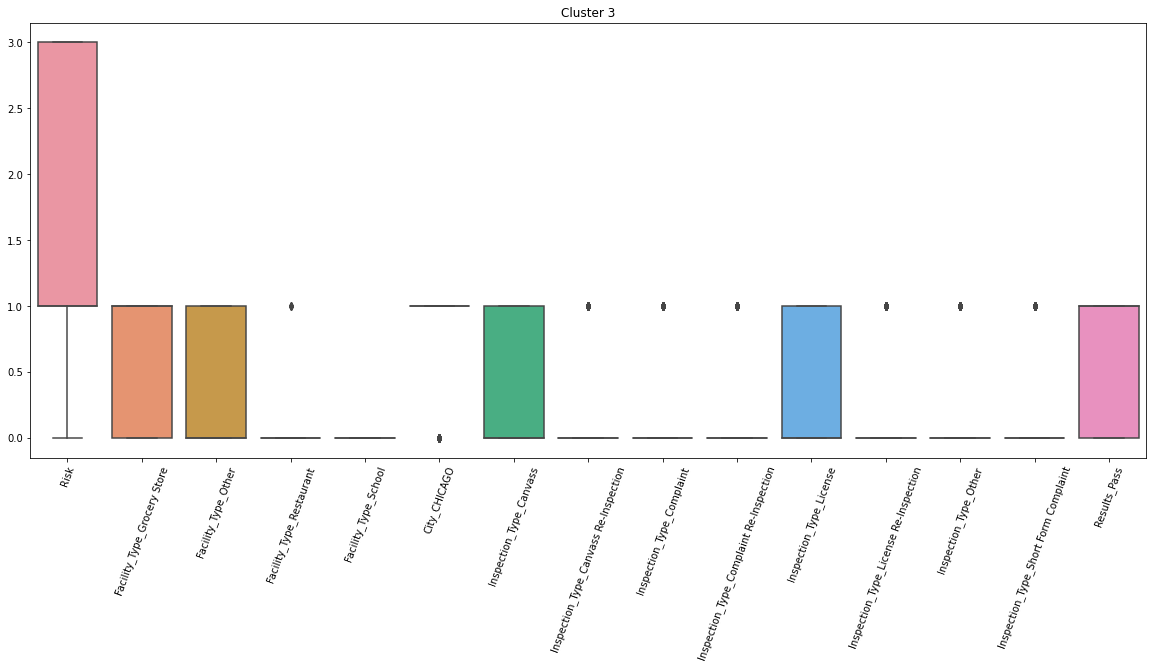

In [ ]:
cluster3bp = cluster3.drop(['Year', 'Month', 'Day', 'Violations_Simple', 'cluster'], axis='columns', inplace=False)
plt.figure(figsize=(20,8))
ax3 = sns.boxplot(data=cluster3bp)
ax3.set_title("Cluster 3")
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=70)
ax3

Some loose trends:
Inspection_Type_License or Inspection_Type_Complaint = 1 tend to mean more failures

Facility_Type_Grocery_Store tends to Pass more often than other facility types


### Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

models = [
    ('lr', lr_grid),
    ('rf', rf)
]

# Combine models to find best ensemble weights
ensemble_model = VotingClassifier(
    estimators=models, 
    voting='soft', 
    flatten_transform=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   26.8s finished


              precision    recall  f1-score   support

           0       0.87      0.92      0.90     12509
           1       0.97      0.95      0.96     34032

    accuracy                           0.94     46541
   macro avg       0.92      0.94      0.93     46541
weighted avg       0.95      0.94      0.94     46541



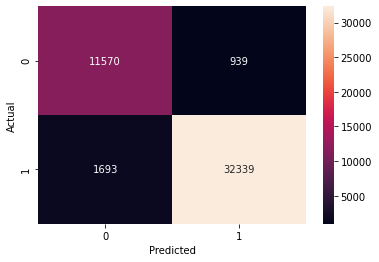

Precision score: 0.972
Recall score: 0.950
Accuracy score: 0.943

 Average precision score: 0.960

Mean squared error: 0.06
Root mean squared error: 0.24
Mean of target variable: 0.731
RMSE percentage of mean: 32.522


In [ ]:
# Fit pipeline
ensemble_model.fit(X_train, y_train) 
predicted = ensemble_model.predict(X_test)

# Print results
classification_report(y_test, predicted)
metrics(y_test, predicted)

In [ ]:
ensemble_model.estimators_

[Pipeline(memory=None,
          steps=[('SMOTE',
                  SMOTE(k_neighbors=5, kind='deprecated',
                        m_neighbors='deprecated', n_jobs=1,
                        out_step='deprecated', random_state=None, ratio=None,
                        sampling_strategy='auto', svm_estimator='deprecated')),
                 ('Scaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('Logistic Regression',
                  GridSearchCV(cv=5, error_score=nan,
                               estimator=Logi...
                                                            max_iter=100,
                                                            multi_class='auto',
                                                            n_jobs=-1,
                                                            penalty='l2',
                                                            random_state=None,
                                               

We do not see improvement with the model by combining the random forest classifier with the logistic regression model.

## **Conclusions**

### Summary

We know certain types of inspections tend to return different results. Can we use the factors that precipitate a certain type of inspection to be proactive with resources, etc to facilities?

We know common Fail Conditions. Can we start a marketing campaign to help facilities with these conditions?

We have a quality model for predicting inspection results. Can we preemptively help facilities that we think will fail?

We know certain facility types are treated differently. Can we start an exploratory committee to determine if these differences are warranted?

### Reccomendations

(Q1) Why restaurants and other food establishments in the city of Chicago fail food inspections.

We see that violations are the primary predictor of failing an inspection when we run our tree model. From this knowledge, we looked further into the violations that caused the most failures, seeing several that had a high correlation with failed inspections.

Common Fail Conditions: 
Rodent or Insect evidence,  Bad Installation or Maintenance of Facilities, Poor Ventilation, Poor Plumbing

(Q2) How food inspectors can proactively help restaurants and other food establishments avoid failing inspections.

Given our investigations into inspection failures due to specific violations, we can target different violation types and promote their fixes to restaurants before we inspect them. By making it clear to these locations that certain standards must be upheld and will otherwise lead to a failed inspection, we may prevent the violations from occuring.

Furthermore, we can look at the different facility types and understand what sort of problems they may face, such as schools having lower rates of reinspection, potentially leading to higher failure-rates, or low risk grocery stores failing more often.

(Q4) If food inspection failures can be accurately predicted.

Using a random forest model, we were able to accuractely predict the passing sites. The models scores on the test set were 0.959 accuracy, 0.981 recall, and 0.964 precision. We can clearly identify and predict which locations with pass or fail based on the observation factors.

(Q3) If food inspection failures may be biased against certain types of facilities or neighborhoods, and how the food inspection process could be improved.

(Q5) How many distinct groups of restaurant and food establishment do we have? What are risks and opportunities associated with each group?

We see 469 different facility types in the raw data. We narrow this down into four groups: schools, restaurants, grocery stores, and other. The raw data may contain duplicate identifiers for the other three groups or may fall under  category, but we considered this out of the scope of our investigation.

We ran clustering analysis and general qualitative looks at the different groups, discovering trends such as inspection types and risk qualifications. Schools recieved different types fo inspections and pass rates than restauarants and grocery stores, who need different types of licenses to operate and as such may face different violations.

Restaurants tend to have higher pass rates than other facilities  

Schools tend to have much lower rates of re-inspection

Grocery Stores tend to be labeled as lower risk, but have higher fail rates

(Q6) Any other relevant details or findings related to the core problem she is facing. 

Inspection Type Trends:
Complaint and License inspections tend to have higher rates of failure
Inspection Type/Risk Trends:
Re-inspections tend to pass more often, where complaint and license inspections fail more often. Lower risk facilities tend to pass inspections